## Business Understanding

Choose stakeholder and figure out what they care about

- need two important parameter estimates as recommendations


## Exploratory Data Analysis

How/why does this data allow you to answer your questions?

**Data Visualization**
- Need 3 High Quality Data Visualizations

## Data Prep/Feature Eng

**Train/Test/Split**

**General Data Preparation**
- Nulls/dupes/outliers
- scaling
- transformations (for linearity)

**Feature Engineering**
- Encoding Variables (categories)
- Polynomial Features
- Interaction Terms
- NEED ONE NON-NUMERIC FEATURE

## Iterative Modeling

First try simplest approach.

Consider what the model baseline is

Start Adding Complexity and compare along the way
(**DOCUMENT THE ITERATIVE PROCESS**)

Models need to adhere to the assumptions of linear regression. If models do not adhere need to at least show that assumptions were tested for:

**ASSUMPTIONS**
- linear relationship between x and y - Heatmaps, scatter matrix
- low multicollinearituy - heatmaps, scatter matrix, VIF
- normal distribution of errors - kde, histogram, QQ-Plot, quantitative check (Jarque-Bera)
- homoskedasticity between errors - scatter plot between true and expected value

## Model Interpretation

Check for statistical Significance - check p-values of input variables

Are coefficients interpretable

Check R2, RMSE, MAE, MSE and other regression metrics

-----------------------


## STAKEHOLDER SELECTION

Stakeholder is Redfin

- Develop model to determine optimal purchasing price of homes and what renovations to make that will lead to greatest ROI


## BUSINESS UNDERSTANDING

**70% Rule:**

$$ 
MBP = (0.7ARV) - ERC
$$

where:

MBP = Maximum Buying Price

ARV = After-repair value

ERC = Estimated repair costs

in a sellers market we can adjust 70% to as high as 85%

## DATA EXPLORATION

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from folium.plugins import FastMarkerCluster
import folium

## Feature Selection

In [19]:
num_features_to_select = 6

# Use RSE or use manual formula string
use_RSE = False
formula_string = 'sqft_living+view+grade+living_area+suburb+rural'

In [20]:
df = pd.read_csv('data/cleaned_data.csv')
df.drop(['id','date','Unnamed: 0'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

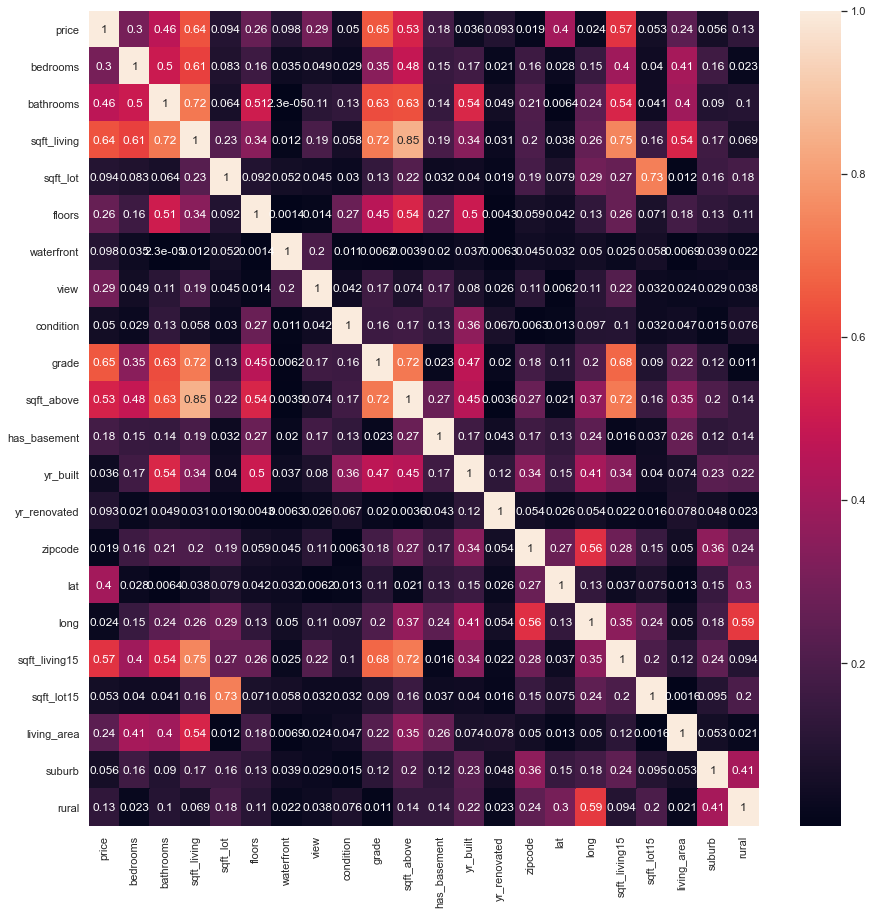

In [21]:
sns.set(rc={'figure.figsize':(15, 15)})

# Use the .heatmap method to depict the relationships visually!
sns.heatmap(df.corr().abs(),annot=True);

In [22]:
# Divide King County up into sections and create a model for each section

lat = 47.5
long = -122.15
# Initialize a folium map to plot points
my_map = folium.Map([lat, long], zoom_start=9)


seattle = [
    # Starting point at Bottom Left of Seattle
    [47.503347, -122.255819],
    [47.734022, -122.255819],
    [47.734022, -122.419374],
    [47.503347, -122.419374],
    [47.503347, -122.255819]
]

suburbs = [
    # Starting point at Top Left of Seattle
    [47.734022, -122.419374],
    [47.777799, -122.419374],
    [47.777799, -121.998473],
    [47.362637, -122.003149],
    [47.288093, -122.177545],
    [47.257529, -122.249917],
    [47.257529, -122.419374],
    [47.503347, -122.419374],
]


# not_seattle = [
#     [47.777799, -122.255819],
#     [47.777799, -121.864468],
#     [47.583466, -121.864468],
#     [47.583466, -121.657316],
#     [47.426793, -121.657316],
#     [47.426793, -121.847579],
#     [47.163963, -121.847579],
#     [47.163963, -122.139281],
#     [47.257529, -122.139281],
#     [47.257529, -122.327981],
#     [47.333580, -122.435077],
#     [47.333580, -122.516673],
#     [47.503347, -122.516673],
#     [47.503347, -122.419374]
    
# ]
rural = [
    [47.503347, -122.419374],
    [47.503347, -122.533756],
    [47.324233, -122.533756],
    [47.324233, -122.419374],
    [47.257529, -122.419374],
    [47.257529, -122.249917],
    [47.161605, -121.924595],
    [47.161605, -121.404507],
    [47.373455, -121.404507],
    [47.600453, -121.131500],
    [47.777799, -121.131500],
    [47.777799, -121.998473],
]

# Plot lines using coordinates
my_PolyLine=folium.PolyLine(locations=rural,weight=7, color = 'yellow')
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=suburbs,weight=5, color = 'green')
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=seattle,weight=3, color = 'blue')
my_map.add_child(my_PolyLine)
# add all the point from the file to the map object using FastMarkerCluster
my_map.add_child(FastMarkerCluster(df[['lat', 'long']].values.tolist()))

my_map

In [23]:
# Shows base dataset corrs
df_base = pd.read_csv('data/kc_house_data.csv')
df_base.drop(['id','date','yr_renovated'],axis=1,inplace=True)
df_base_corrs = df_base.corr()['price'].map(abs).sort_values(ascending=False)
df_base_corrs[:5]

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
Name: price, dtype: float64

In [24]:
# Shows cleaned dataset corrs
df_corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs[:5]

price            1.000000
grade            0.649461
sqft_living      0.639017
sqft_living15    0.572739
sqft_above       0.530734
Name: price, dtype: float64

In [25]:
# Create Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.2, random_state=42)

In [26]:
# Fit Scalar to Train
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [27]:
# Recursive Feature Selection
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
select.fit(X=X_train_scaled, y=y_train)


keep_list = [(k,v) for k,v in zip(df.drop('price', axis=1).columns,select.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
if use_RSE == False:
    keep_list = formula_string.split('+')
keep_string = keep_string[:-1]

In [28]:
# Creates scaled features dataframe and then adds on price column

# Train
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = df.drop('price', axis=1).columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled,y_train),axis=1)

# Test
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df.drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

----------------

## Model Results

In [29]:
# Baseline Model

baseline_mean = X_train_scaled_final['price'].mean()
model_base = DummyRegressor(strategy='mean', constant=baseline_mean)
baseline_mean

499116.46736483194

In [30]:
# OLS Regression on Train Data

if use_RSE == False:
    keep_string = formula_string

formula = f'price ~ {keep_string}'
model = ols(formula,X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     4232.
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:56:44   Log-Likelihood:            -2.1988e+05
No. Observations:               16424   AIC:                         4.398e+05
Df Residuals:                   16417   BIC:                         4.398e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.991e+05   1231.526    405.283      0.000    4.97e+05    5.02e+05
sqft_living  1.372e+05   2300.140     59.648      0.000    1.33e+05    1.42e+05
view         3.027e+04   1276.707     23.710      0.000    2.78e+04    3.28e+04
grade        7.814e+04   1881.957     41.522      0.000    7.45e+04    8.18e+04
living_area -3.722e+04   1588.923    -23.427      0.000   -4.03e+04   -3.41e+04
suburb      -7.634e+04   1440.480    -52.996      0.000   -7.92e+04   -7.35e+04
rural       -7.303e+04   1404.678    -51.994      0.000   -7.58e+04   -7.03e+04
==============================================================================
Omnibus:                     3286.787   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10154.332
Skew:                           1.030   Prob(JB):                         0.00
Kurtosis:                       6.255   Cond. No.                         3.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# OLS Regression on Test Data

model_test = ols(formula,X_test_scaled_final).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     952.7
Date:                Tue, 05 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:56:49   Log-Likelihood:                -54945.
No. Observations:                4106   AIC:                         1.099e+05
Df Residuals:                    4099   BIC:                         1.099e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.955e+05   2449.983    202.249      0.000    4.91e+05       5e+05
sqft_living  1.321e+05   4537.714     29.114      0.000    1.23e+05    1.41e+05
view         2.925e+04   2523.943     11.588      0.000    2.43e+04    3.42e+04
grade        7.535e+04   3739.694     20.150      0.000     6.8e+04    8.27e+04
living_area -3.266e+04   3074.560    -10.623      0.000   -3.87e+04   -2.66e+04
suburb      -7.943e+04   2843.360    -27.935      0.000    -8.5e+04   -7.39e+04
rural       -7.412e+04   2781.209    -26.651      0.000   -7.96e+04   -6.87e+04
==============================================================================
Omnibus:                      841.510   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2722.114
Skew:                           1.029   Prob(JB):                         0.00
Kurtosis:                       6.417   Cond. No.                         3.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-------------

## MODEL VALIDATION

### Check Normal Distribution of Input Variables

In [ ]:
if use_RSE:
    df.filter([x[0] for x in keep_list if x[1] == True],axis=1).plot.kde(subplots=True,sharex=False)
else:
    df.filter(keep_list,axis=1).plot.kde(subplots=True,sharex=False)
plt.show()

### Checking Normal Distribution of Residuals

In [ ]:
y_hat_train = model.predict(X_train_scaled)
y_hat_test = model_test.predict(X_test_scaled)

qqplot(y_train-y_hat_train,line='r')
plt.show()

### Checking for Heteroskedasticity and Lack of Trend in Errors

In [ ]:
plt.scatter(y_hat_train, y_train - y_hat_train, label='Train')
plt.scatter(y_hat_test, y_test - y_hat_test, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Checking Root Mean Squared Error

In [ ]:
print('TRAIN RMSE:',rmse(y_train,y_hat_train))
print('TEST RMSE:',rmse(y_test,y_hat_test))
print('RMSE DIFF:', abs(rmse(y_train,y_hat_train)-rmse(y_test,y_hat_test)))

### Checking Linearity and Multicollinearity

In [ ]:
if use_RSE:
    scatter_keep_list = keep_list.copy()
    scatter_keep_list.append(('price',True))
    pd.plotting.scatter_matrix(df.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1))
    plt.show()

else:
    scatter_keep_list = keep_list.copy()
    scatter_keep_list.append('price')
    pd.plotting.scatter_matrix(df.filter(scatter_keep_list,axis=1))
    plt.show()

In [ ]:
if use_RSE:
    corr_print = X_train_scaled_final.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs()['price'].sort_values(ascending=False)
else:
    corr_print = X_train_scaled_final.filter(scatter_keep_list,axis=1).corr().abs()['price'].sort_values(ascending=False)
corr_print

In [ ]:
if use_RSE:
    sns.heatmap(X_train_scaled.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs(),annot=True)
else:
    sns.heatmap(X_train_scaled.filter(keep_list,axis=1).corr().abs(),annot=True)